# Baseball
+ This is a Bayesian practice in analyzing Baseball statistics. Many thanks to the great blog @[Variance Explained](http://varianceexplained.org/).

------------
### Objective
Faily evaluating the performance of a player could be hard sometimes when there is little information available. It might be suspicious to say a player, who keeps a record of batting average 8/10, is better than another one, who gets an average 200/500. Now, let Bayesian Statistics make help. This practice was conducted under the guidance from blog @[Variance Explained](http://varianceexplained.org/). It covers empirical Bayesian prior estimates, hierarchical modeling, mixture model, hypothese testing and simulation.

### Data Description
To access to the data, click the [link](https://github.com/chadwickbureau/baseballdatabank)!

Variable|Definition|Note
---|---|---
playerID|A unique code asssigned to each player|The playerID links the data in this file with records in the other files
nameFirst|Player's first name|
nameLast|Player's last name|
bats|Player's batting hand|L = left handed, R = Right handed, B = Both
lgID|League|
AB|At Bats| 
H|Hits|
G|Games played|
-------
### Under Construction
Comments and fomatting

--------

### Setup
+ In this project, I focus on players in National League with a number of batting bigger than 20.
+ Besides number of Hits (H) and At Bats (AB), we will also exlpore the difference between pitchers and batters, and difference between left-handed players and right-handed players.

In [1]:
PLUGIN_PATHS = ['/Users/zhenhongyang/zhenhongy.github.io/pelican-plugins']
PLUGINS = ['assets', 'sitemap', 'gravatar']

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import math
pd.options.mode.chained_assignment = None
seed = 2016

In [2]:
batting = pd.read_csv('batting.csv')
master = pd.read_csv('master.csv')
pitching = pd.read_csv('pitching.csv')

In [3]:
pitching = pitching.groupby('playerID',as_index = False).sum()
pitching = pitching[pitching.G > 3]
batting = batting[(batting.lgID == 'NL') & (batting.yearID > 1980)]
batting = batting.groupby(['playerID'],as_index = False).sum()
batting = batting[(batting.AB > 20)]
batting['isPitcher'] = batting.playerID.isin(pitching.playerID)
master[['nameFirst','nameLast']] = master[['nameFirst','nameLast']].fillna('NaN')
master['name'] = master[['nameFirst','nameLast']].apply(lambda x: ' '.join(x), axis = 1)

In [4]:
df = pd.merge(batting, master, how = 'left', on = 'playerID')
df = df[~pd.isnull(df.bats)]

In [5]:
career = df[['name','H','AB','isPitcher','bats']]
career['Average_rate'] = df.H.astype(float) / df.AB
career = pd.get_dummies(career, columns = ['bats'])
num = len(career)
p_ind = career.index[career.isPitcher].tolist()
np_ind = career.index[~career.isPitcher].tolist()

In [6]:
career.head(10)

,name,H,AB,isPitcher,Average_rate,bats_B,bats_L,bats_R
0,Jeff Abbott,11,42,False,0.261905,0,0,1
1,Jim Abbott,2,21,True,0.095238,0,1,0
2,Kurt Abbott,475,1860,False,0.255376,0,0,1
3,Kyle Abbott,3,31,True,0.096774,0,1,0
4,Reggie Abercrombie,86,386,False,0.222798,0,0,1
5,Shawn Abner,110,531,False,0.207156,0,0,1
6,Bobby Abreu,1607,5395,False,0.297868,0,1,0
7,Tony Abreu,129,509,False,0.253438,1,0,0
8,Jose Acevedo,8,101,True,0.079208,0,0,1
9,Juan Acevedo,6,65,True,0.092308,0,0,1


### Exploration
+ Usually, we model rate parameter with a prior beta distribution.
+ However, the historical batting rate does not follow a simple beta distribution. It is because data mixes both pitchers and non-pitchers. If we seperate them, each group basically follows a specific beta distribution. To handle multi-distribution data, we could try mixture effect model.
+ According to the relation between AB and batting rate, it is possible to say that the more chance you play, the higher batting rate you should have. (Or conversely! The better performance you are, the more chance you could play) And it is more abvious for non-pitchers!
+ There is no significant difference between left-handed player and right-handed player.

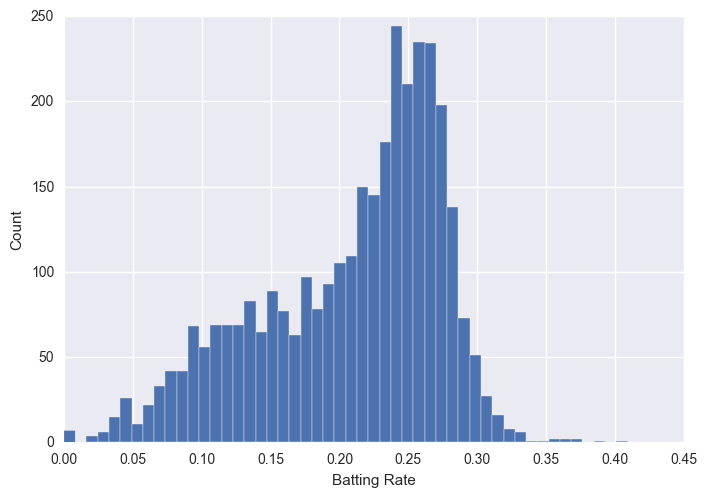

In [7]:
plt.figure()
plt.hist(x = career.Average_rate, bins = 50)
plt.xlabel('Batting Rate')
plt.ylabel('Count')
plt.show()

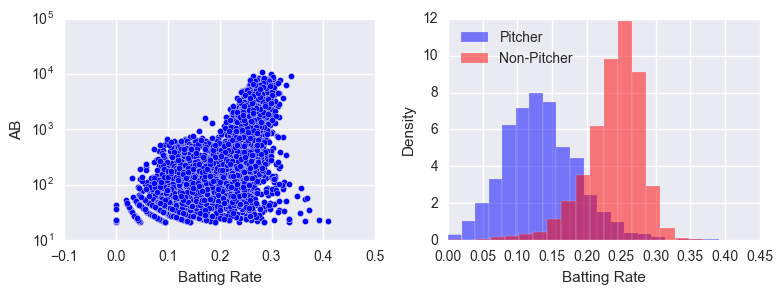

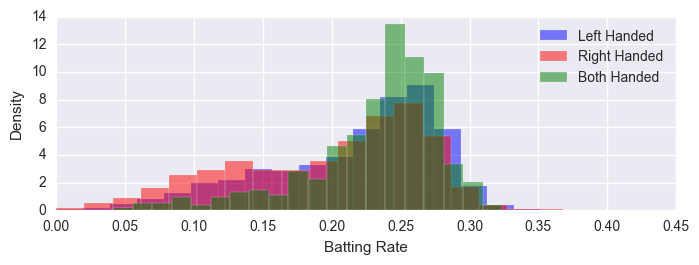

In [8]:
plt.figure()

ax1 = plt.subplot(221)
ax1.scatter(career.Average_rate, career.AB)
ax1.set_ylabel('AB')
ax1.set_xlabel('Batting Rate')
plt.yscale('log',base = 10)

ax2 = plt.subplot(222)
ax2.hist(career.Average_rate[p_ind], bins = 20, color = 'b', label = 'Pitcher', alpha = 0.5, normed = True)
ax2.hist(career.Average_rate[np_ind], bins = 20, color = 'r', label = 'Non-Pitcher', alpha = 0.5, normed = True)
ax2.set_ylabel('Density')
ax2.set_xlabel('Batting Rate')
plt.legend(loc = 'best')
plt.tight_layout(w_pad=1)

plt.figure()
ax3 = plt.subplot(211)
ax3.hist(career.Average_rate[career.bats_L == 1], bins = 20, color = 'b', label = 'Left Handed', alpha = 0.5, normed = True)
ax3.hist(career.Average_rate[career.bats_R == 1], bins = 20, color = 'r', label = 'Right Handed', alpha = 0.5, normed = True)
ax3.hist(career.Average_rate[career.bats_B == 1], bins = 20, color = 'g', label = 'Both Handed', alpha = 0.5, normed = True)
ax3.set_ylabel('Density')
ax3.set_xlabel('Batting Rate')
plt.legend(loc = 'best')

plt.show()

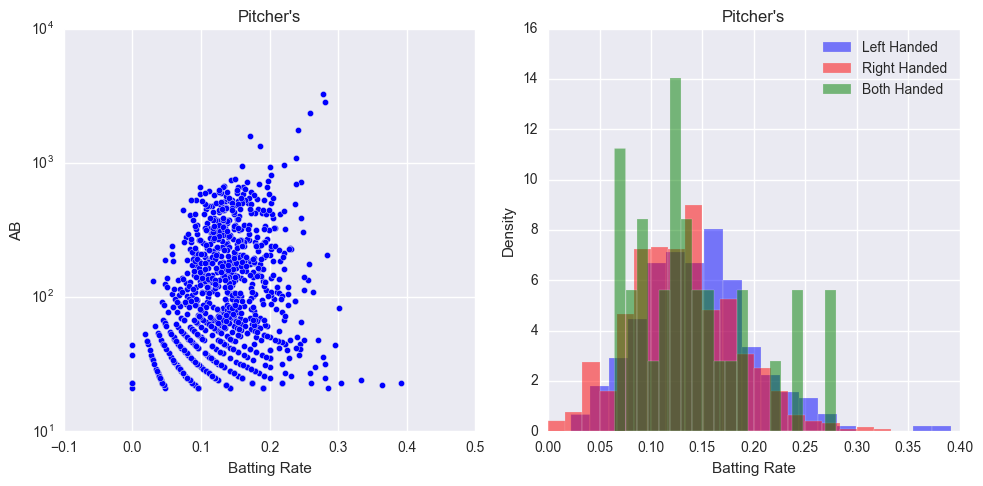

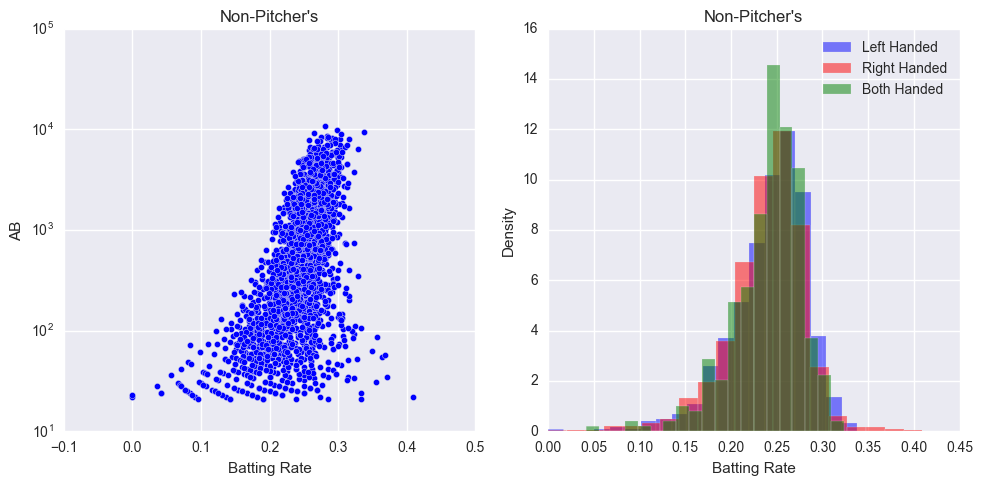

In [9]:
full_data = {'Pitcher': career.iloc[p_ind], 'Non-Pitcher': career.iloc[np_ind]}
for key in full_data.keys():
    dataset = full_data[key]
    plt.figure(figsize = (10,5))

    ax1 = plt.subplot(121)
    ax1.scatter(dataset.Average_rate, dataset.AB)
    ax1.set_ylabel('AB')
    ax1.set_xlabel('Batting Rate')
    plt.yscale('log',base = 10)
    ax1.set_title('%s\'s' % key)
    
    ax2 = plt.subplot(122)
    ax2.hist(dataset.Average_rate[dataset.bats_L == 1], bins = 20, color = 'b', label = 'Left Handed', alpha = 0.5, normed = True)
    ax2.hist(dataset.Average_rate[dataset.bats_R == 1], bins = 20, color = 'r', label = 'Right Handed', alpha = 0.5, normed = True)
    ax2.hist(dataset.Average_rate[dataset.bats_B == 1], bins = 20, color = 'g', label = 'Both Handed', alpha = 0.5, normed = True)
    ax2.set_ylabel('Density')
    ax2.set_xlabel('Batting Rate')
    plt.legend(loc = 'best')
    ax2.set_title('%s\'s' % key)
    
    plt.tight_layout(w_pad = 1)
    plt.show()

### Batting Rate Adjustment (Bayesian posterior estimates)
+ In this section, we will use Emperical Bayesian approach to estimate prior. Both simple approach (Method of Moment) and mixture effects approach (with/without considering factor AB) will be used.
+ The Bayesian posterior estimate (let's name it 'Shrinkage Batting Rate', comparing to previous 'Raw Batting Rate' = H/AB) is an alternative measurement of player's batting rate, which is more accurate in describing player's performance when he only played a few games. 

In [10]:
def posterior(alpha, beta, h, n):
    alpha_post = alpha + h
    beta_post = beta + n - h
    mean = alpha_post / (alpha_post + beta_post)
    return alpha_post, beta_post, mean

def fitcheck(ax, ar, alpha, beta, weight = 1.0, xlabel = 'Raw Batting Rate', label = None, title = None, normed = True, bins = 50, color = 'b'):    
    ax.hist(x = ar, bins = bins, normed = normed, color = color, label = label, alpha = 0.5)
    x = np.linspace(0,np.max(ar) * 1.05,500)
    pdf = sp.stats.beta.pdf(x, alpha, beta) * weight
    ax.plot(x, pdf, '-', color = color)
    ax.set_ylabel('Density')
    ax.set_xlabel(xlabel)
    if title != None:
        ax.set_title(title)
    if label != None:
        plt.legend(loc = 'best')

def postscatter(ax, xdata, ydata, alpha=0.9, xlabel = None, ylabel = None, title = None, \
                c = None, colorbar = False, colorbar_title = None, color_ticks = None, params = {}): 
    
    if np.any(c) == None:
        c = 'b'
        cmap = None
    else:
        cmap = plt.cm.winter
    params['alpha'] = alpha
    params['c'] = c
    params['cmap'] = cmap
    
    sc = ax.scatter(xdata, ydata, **params)
    
    if (colorbar) & (cmap != None):
        ticks = np.unique(np.round(c))
        cb = plt.colorbar(sc, ticks = ticks)
        if color_ticks == None:
            cb.ax.set_yticklabels([int(x) for x in (10 ** ticks)])
        else:
            cb.ax.set_yticklabels(color_ticks)
        if colorbar_title != None:
            cb.ax.set_title(colorbar_title)
            
    y = np.arange(0.0,0.45,0.01)
    ax.plot(y,y,'r',alpha=0.4)
    
    if xlabel != None:
        ax.set_xlabel(xlabel)
    if ylabel != None:
        ax.set_ylabel(ylabel)
    if title != None:
        ax.set_title(title)
    
    ax.set_xlim([-0.01,0.45])
    ax.set_ylim([-0.01,0.45])

#### A. Prior with Beta Distribution (Method of Moment)
+ Simple beta distribution could not precisely match the distribution of batting rate over a mixed population. If we do it to different groups serperately, beta disrtribution is a good fit to each group.
+ The bigger AB, the closer between raw batting rate and shrinkage batting rate.
+ The bigger AB, the smaller range of credible interval. (In the scatter plot, the bigger the dot, the bigger the range of credible intervel.)

In [11]:
def mm(rate):
    mu = np.mean(rate)
    var = np.mean(rate ** 2) - np.mean(rate) ** 2
    ab = mu * (1-mu) / var - 1
    alpha = mu * ab
    beta = (1 - mu) * ab
    return alpha, beta

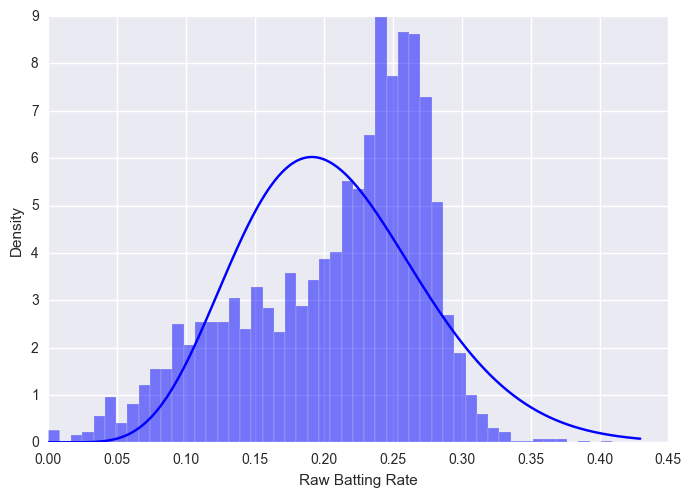

In [12]:
alpha0, beta0 = mm(career.Average_rate)

f, ax = plt.subplots(1,1)
fitcheck(ax, career.Average_rate, alpha0, beta0)
plt.show()

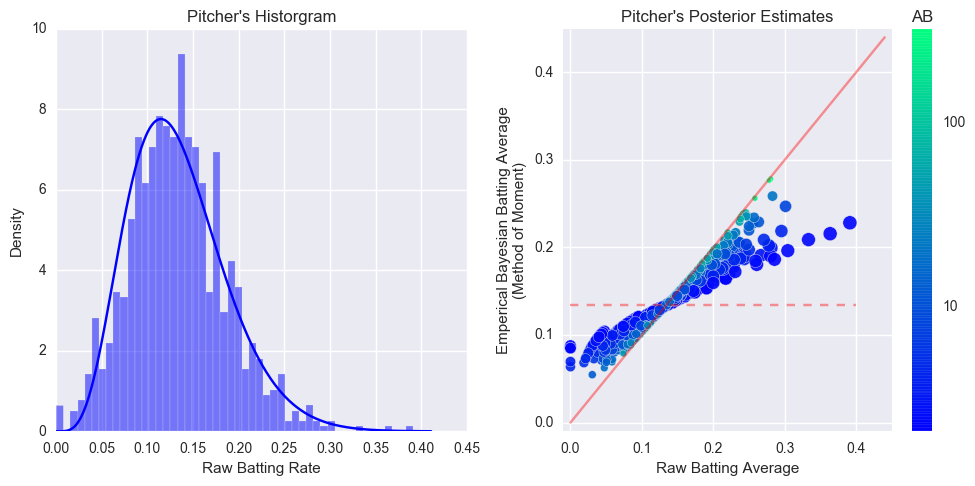

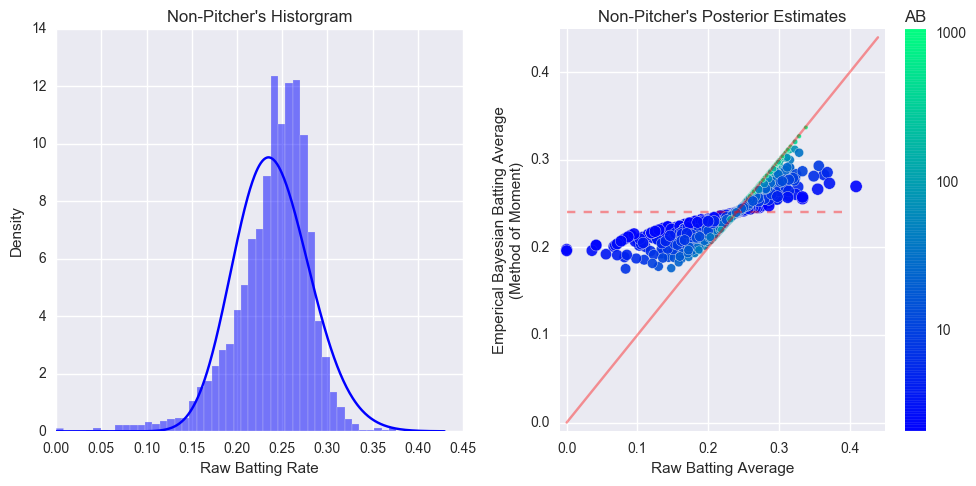

In [13]:
full_data = {'Pitcher': career.loc[p_ind], 'Non-Pitcher': career.loc[np_ind]}
for key in full_data.keys():
    dataset = full_data[key]
    alpha0, beta0 = mm(dataset.Average_rate)
    alpha0_post, beta0_post, ar0_post = posterior(alpha0, beta0, dataset.H, dataset.AB)
    ci = np.stack([sp.stats.beta.ppf(0.025, alpha0_post, beta0_post), sp.stats.beta.ppf(0.975, alpha0_post, beta0_post)],axis=1)
    
    plt.figure(figsize = (10,5))
    ax1 = plt.subplot(121)
    fitcheck(ax1, dataset.Average_rate, alpha0, beta0, title = '%s\'s Historgram' % key)
    
    ax2 = plt.subplot(122)
    params = {'s': 500*np.array([u-l for l,u in ci])}
    postscatter(ax2, dataset.Average_rate, ar0_post, c = np.log10(dataset.AB), colorbar = True, colorbar_title = 'AB', \
                params = params, xlabel = 'Raw Batting Average', ylabel = 'Emperical Bayesian Batting Average\n(Method of Moment)', \
                title = '%s\'s Posterior Estimates' % key)
    x = np.arange(0, 0.5, 0.1)
    ax2.plot(x,np.array([alpha0 / (alpha0 + beta0)] * len(x)),'r--',alpha=0.4)
    
    plt.tight_layout(w_pad = 1)
    plt.show()

#### B. Prior with Mixture Effect Beta-Binomial Model
+ Suppose we have no idea about who is pitcher or not, we are not able to do simple prior estimate. Instead, we could try to use mixture effect model.
+ As shown in the data exploration, factor AB is highly related to raw batting rate. Thus it is possible that AB could be some hints to the actual batting rate. We will try models with and without factor AB and compare models, accuracy in segmenting players.
+ Note: In this section, we will use Beta-Binomial distribution, rather than Beta distribution.

#### B1. No factors
+ Mixture effect model could basically seperate players and gives density which fits each group well.
+ In this model, most pitchers' raw batting rates are smaller than model expectation. And most pitchers' shrinkage batting rates are raised from their raw batting rate since most of them play only a few games.

In [14]:
from scipy.optimize import minimize
from scipy.special import gammaln

def bb(s, n, a, b):
    return gammaln(n+1) + gammaln(s+a) + gammaln(n-s+b) + gammaln(a+b) \
            - (gammaln(s+1) + gammaln(n-s+1) + gammaln(a) + gammaln(b) + gammaln(a + b + n))

def ll_bb(para, data):
    alpha = para[0]
    beta = para[1]
    ll = - np.sum(bb(data.H, data.AB, alpha, beta))
    return ll

def fit_mle_bb(data, para = None):
    if para == None:
        a, b = mm((data.H + 0.0) / data.AB)
        para = [a , b]
    res = minimize(ll_bb, x0 = para, args = data, method = 'BFGS')
    alpha, beta = res.x
    return alpha, beta
    
def mix_bb(data, n, k, random_state = None):
    if random_state != None:
        np.random.seed(random_state)

    z = np.array([np.random.permutation([0] * (k-1) + [1]) for i in range(len(data))])
    p = z.sum(axis = 0) / float(len(data))
    lp = np.array([0.0] * len(data) * k).reshape(len(data),k)

    para = {'alpha': np.ndarray((n,k)),
            'beta':np.ndarray((n,k)),
            'prior':np.ndarray((n,k))}
    
    for i in range(n):
        for j in range(k):
            a, b = fit_mle_bb(data[z[:,j] == 1])
            lp[:,j] = np.exp(bb(data.H, data.AB, a, b)) * p[j]
            para['alpha'][i,j] = a
            para['beta'][i,j] = b
        z = np.apply_along_axis(lambda x: x == np.max(x), 1 , lp)
        p = z.sum(axis = 0) / float(len(data))
        para['prior'][i,:] = p

    return para

In [15]:
iteration = 9
para_1 = mix_bb(career, iteration, 2, seed)

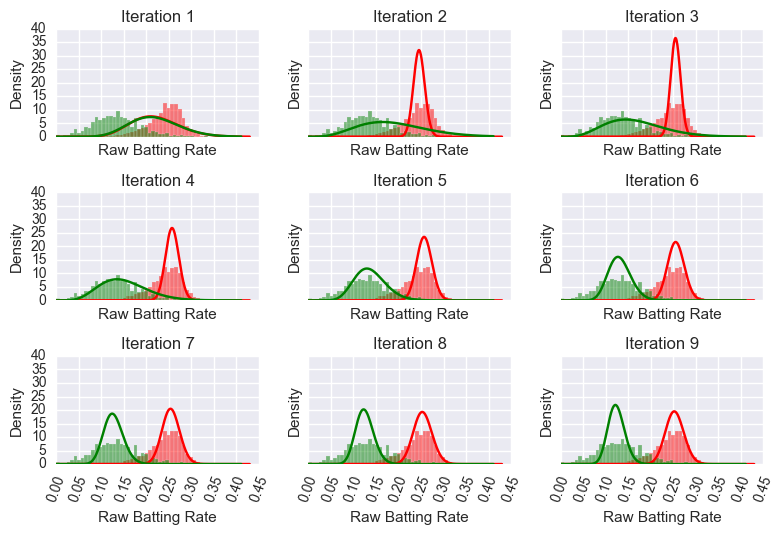

In [16]:
f, ax = plt.subplots(3,3,sharex = True,sharey = True)
for i in range(iteration):
    row, column = i / 3, i % 3
    fitcheck(ax[row, column],career.Average_rate[np_ind], para_1['alpha'][i][0], para_1['beta'][i][0], color = 'r', title = 'Iteration %d' %(i + 1))
    fitcheck(ax[row, column],career.Average_rate[p_ind], para_1['alpha'][i][1], para_1['beta'][i][1], color = 'g')
    plt.setp(ax[row, column].xaxis.get_majorticklabels(), rotation=70)
plt.tight_layout(h_pad = 1)
plt.show()

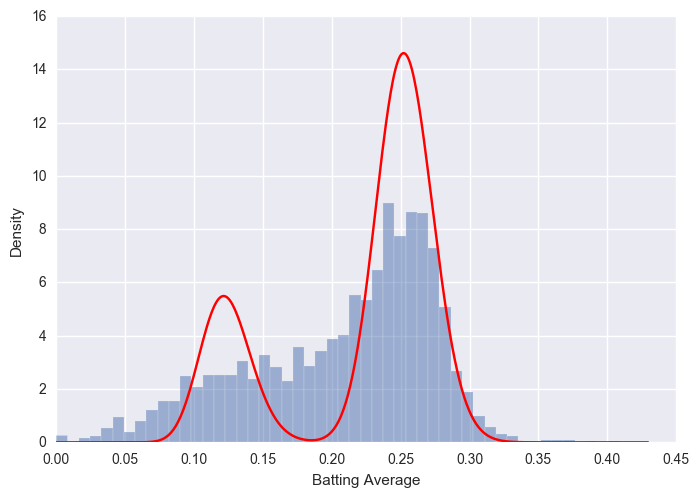

In [17]:
plt.figure()
plt.hist(career.Average_rate, bins = 50, normed = True, alpha = 0.5)
x = np.linspace(0,np.max(career.Average_rate) * 1.05,500)
pdf = sp.stats.beta.pdf(x, para_1['alpha'][-1][0],  para_1['beta'][-1][0]) *  para_1['prior'][-1][0] \
    + sp.stats.beta.pdf(x, para_1['alpha'][-1][1],  para_1['beta'][-1][1]) *  para_1['prior'][-1][1]
plt.plot(x, pdf, '-', color = 'r')
plt.xlabel('Batting Average')
plt.ylabel('Density')
plt.show()

In [18]:
para_1 = np.array([para_1[key][-1] for key in para_1.keys()])

In [19]:
#Assign using beta-binomial distribution
post1_1 = np.exp( bb(career.H, career.AB, para_1[0][0], para_1[1][0]) ) * para_1[2][0]
post2_1 = np.exp( bb(career.H, career.AB, para_1[0][1], para_1[1][1]) ) * para_1[2][1]
post1_1 = post1_1 / (post1_1 + post2_1)
post2_1 = 1 - post1_1
isPitcher_guess1 = post2_1 > post1_1

In [20]:
alpha_1_post, beta_1_post = np.array([para_1[0] + s for s in career.H]) , np.array([para_1[1] + n - s for s, n in zip(career.H, career.AB)])

In [21]:
#Posterior Estimates
alpha_1_post, beta_1_post = np.array([para_1[0] + s for s in career.H]) , np.array([para_1[1] + n - s for s, n in zip(career.H, career.AB)])
ar_1_post = np.sum((alpha_1_post / (alpha_1_post + beta_1_post)) * para_1[2], axis = 1) 

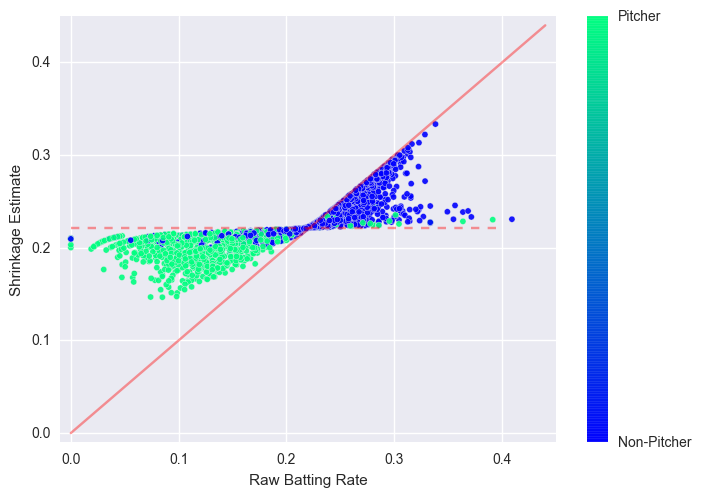

In [22]:
plt.figure()

ax = plt.subplot(111)
postscatter(ax, career.Average_rate, ar_1_post, xlabel = 'Raw Batting Rate', ylabel = 'Shrinkage Estimate', \
            c = career.isPitcher, colorbar = True, color_ticks = ['Non-Pitcher','Pitcher'])
x = np.arange(0, 0.5, 0.1)
ax.plot(x, np.array([np.sum((para_1[0] / (para_1[0] + para_1[1])) * para_1[2])] * len(x)),'r--',alpha=0.4)

plt.show()

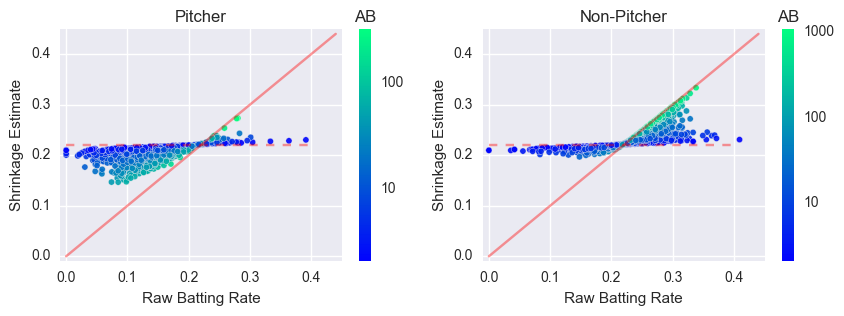

In [23]:
plt.figure(figsize = (10,3))
x = np.arange(0, 0.5, 0.1)

ax1 = plt.subplot(121)
postscatter(ax1, career.Average_rate[p_ind], ar_1_post[p_ind], xlabel = 'Raw Batting Rate', \
            ylabel = 'Shrinkage Estimate', title = 'Pitcher', c = np.log10(career.AB[p_ind]), \
            colorbar = True, colorbar_title = 'AB')
ax1.plot(x, np.array([np.sum((para_1[0] / (para_1[0] + para_1[1])) * para_1[2])] * len(x)),'r--',alpha=0.4)

ax2 = plt.subplot(122)
postscatter(ax2, career.Average_rate[np_ind], ar_1_post[np_ind], xlabel = 'Raw Batting Rate', \
            ylabel = 'Shrinkage Estimate', title = 'Non-Pitcher', \
            c = np.log10(career.AB[np_ind]), colorbar = True, colorbar_title = 'AB')
ax2.plot(x, np.array([np.sum((para_1[0] / (para_1[0] + para_1[1])) * para_1[2])] * len(x)),'r--',alpha=0.4)

plt.show()

B2. Factor AB

In [24]:
import statsmodels.api as sm
import bbreg
transform_log = sm.families.links.Log()
transform_logit = sm.families.links.Logit()

In [81]:
def mix_beta_factor(h, ab, exog, n, k, label_factor = None, random_state = None):
    np.random.seed(random_state)
    
    num_obs = len(h)
    exog = sm.add_constant(exog, prepend = True)
    num_factor = exog.shape[1]
    if label_factor != None:
        assert((num_factor - 1) == len(label_factor))
        label_factor = ['Intercept'] + label_factor
    
    para = {'prior':np.ndarray((n,k)),
                        'phi': np.ndarray((n,k))}
    for m in range(num_factor):
        if label_factor == None:
            para['coef_%s' % m] = np.ndarray((n,k))
        else:
            para[label_factor[m]] = np.ndarray((n,k))
    
### z = np.apply_along_axis(np.random.permutation, 1, np.array([[0] * (k - 1) + [1],] * num_obs))
    lp = np.random.dirichlet(np.ones(k) ,size = num_obs)
    p = np.mean(lp, axis = 0)
    
    for i in range(n):
        for j in range(k):
            model = bbreg.BB(endog = np.stack([h, ab - h],axis = 1), exog = exog, weights = lp[:,j])
            params = model.fit().params
            mu = transform_logit.inverse(np.dot(exog, params[0:-1].T))
            phi = transform_log.inverse(params[-1])
            lp[:,j] = gammaln(ab+1) + gammaln(h+phi * mu) + gammaln(ab - h + phi * (1 - mu)) + gammaln(phi) \
            - (gammaln(h+1) + gammaln(ab-h+1) + gammaln(mu * phi) + gammaln(phi * (1 - mu)) + gammaln(phi + ab))
            lp[:,j] = lp[:,j] * p[j]
            for m in range(num_factor):
                if label_factor == None:
                    para['coef_%s' %(m)][i,j] = params[m]
                else:
                    para[label_factor[m]][i,j] = params[m]
            para['phi'][i,j] = params[-1]
        lp = np.array([x / sum(x) for x in lp])
###     z = np.apply_along_axis(lambda: x == max(x), 0, lp)
        p = np.mean(lp, axis = 0)
        para['prior'][i,:] = p

    return para

In [82]:
i = career.AB < 1000
para_2 = mix_beta_factor(career.H[i], career.AB[i], np.log10(career.AB[i]),20,2, random_state = seed)

In [83]:
para_2

{'coef_0': array([[-2.27618055, -2.25425505],
        [-2.26964346, -2.26262476],
        [-2.26360401, -2.26865275],
        [-2.26712809, -2.26509905],
        [-2.26577923, -2.26645825],
        [-2.2662248 , -2.26600933],
        [-2.26608761, -2.26614755],
        [-2.26612825, -2.2661066 ],
        [-2.26611648, -2.26611845],
        [-2.26611985, -2.26611507],
        [-2.26611889, -2.26611604],
        [-2.26611916, -2.26611576],
        [-2.26611909, -2.26611585],
        [-2.26611911, -2.26611582],
        [-2.2661191 , -2.26611583],
        [-2.26611911, -2.26611582],
        [-2.2661191 , -2.26611582],
        [-2.26611911, -2.26611583],
        [-2.26611911, -2.26611582],
        [-2.26611911, -2.26611583]]),
 'coef_1': array([[ 0.51922088,  0.50416894],
        [ 0.5123519 ,  0.51194305],
        [ 0.5114471 ,  0.51282832],
        [ 0.51245755,  0.51180896],
        [ 0.51202022,  0.51224965],
        [ 0.51217197,  0.51209676],
        [ 0.51212407,  0.51214502],
      

In [84]:
sum(career.AB[career.isPitcher] < 1000) / float(sum(career.AB < 1000))

0.39230464101547008

In [ ]:
mu_2 = transform_logit.inverse(np.array([para_2['coef_0'] + para_2['coef_1'] * b for b in bins[1:]]))
phi_2 = transform_log.inverse(para_2['phi'])
alpha_2 = mu_2 * np.array([phi_2,]*3)
beta_2 = np.array([phi_2,]*3) - alpha_2

In [ ]:
transform_log.inverse(para_2['phi'])

plot distribution fit for each level of AB

In [ ]:
bins = range(int(min(np.floor(np.log10(career.AB)))),int(max(np.ceil(np.log10(career.AB)))))
labels = np.power(10,bins)[1:]
cat = pd.cut(np.log10(career.AB),bins = bins, labels = labels)
ind_ab = [cat[cat == l].index.values for l in labels]

In [ ]:
for j in range(len(labels)):    
    label = labels[j]
    index = ind_ab[j]
    dataset = career.iloc[index,:]
    
    f, ax = plt.subplots(3,3,sharex = True,sharey = True)
    for i in range(iteration):
        row, column = i / 3, i % 3
        fitcheck(ax[row, column],dataset.Average_rate[np_ind].dropna(), alpha_2[j][i][0], beta_2[j][i][0], color = 'r', title = 'AB <= %s Iteration %d' %(label,(i + 1)))
        fitcheck(ax[row, column],dataset.Average_rate[p_ind].dropna(), alpha_2[j][i][1], beta_2[j][i][1], color = 'g')
        plt.setp(ax[row, column].xaxis.get_majorticklabels(), rotation=70)
    plt.tight_layout(h_pad = 1)
    plt.show()

In [ ]:
para_1 = np.array([para_1[key][-1] for key in para_1.keys()])

In [ ]:
coef0_1, coef1_1, phi_1, prior_1 = para1['coef_0'][-1], para1['coef_1'][-1], para1['phi'][-1], para1['prior'][-1]

In [ ]:
model = bbreg.BB(np.stack([career.H, career.AB - career.H],axis = 1), np.log(career.AB))
post1_1 = - model._ll_br(np.stack([career.H, career.AB - career.H],axis = 1), sm.add_constant(np.log(career.AB), prepend = True), np.ones((len(career), 1), dtype='f'), [coef0_1[0],coef1_1[0],phi_1[0]]) * prior_1[0]
post2_1 = - model._ll_br(np.stack([career.H, career.AB - career.H],axis = 1), sm.add_constant(np.log(career.AB), prepend = True), np.ones((len(career), 1), dtype='f'), [coef0_1[1],coef1_1[1],phi_1[1]]) * prior_1[1]
post1_1 = post1_1 / (post1_1 + post2_1)
post2_1 = 1 - post1_1
isPitcher_guess1 = post1_1 > post2_1

In [ ]:
#Posterior
mu1 = transform_logit.inverse(np.array([coef0_1 + coef1_1 * x for x in np.log(career.AB)]))
phi1 = transform_log.inverse(phi_1)
alpha_1_post, beta_1_post = np.array([x * phi1 + s for x, s in zip(mu1,career.H)]), np.array([phi1 - x * phi1 + n - s for x, s, n in zip(mu1, career.H, career.AB)])
ar_1_post = np.sum(np.array([x / (x + y) for x, y in zip(alpha_1_post, beta_1_post)])* np.stack([post1_1,post2_1],axis=1), axis = 1) 

In [ ]:
fig = plt.figure()

ax3_1 = plt.subplot(111) 
ax3_1.scatter(career.AB[career.isPitcher], ar_1_post[np.array(career.isPitcher)], c = 'b', label = 'Pitcher', alpha = 0.7)
ax3_1.scatter(career.AB[~career.isPitcher], ar_1_post[np.array(~career.isPitcher)], c = 'g', label = 'Non-Pitcher', alpha = 0.7)
ax3_1.set_xlabel('AB')
ax3_1.set_ylabel('EB Batting Average\n(Mix Effect with Factor AB)')
ax3_1.set_xscale('log')
plt.xlim([5,20000])
plt.ylim([-0.01,0.45])
plt.legend(loc=2)

plt.show()

In [ ]:
fig = plt.figure()
x = np.arange(0.0,0.5,0.01)

ax3_2 = plt.subplot(111) 
ax3_2.scatter(career.Average_rate[career.isPitcher], ar_1_post[np.array(career.isPitcher)], s = 6 * np.log(career.AB[career.isPitcher]), c = 'b', label = 'Pitcher', alpha = 0.6)
ax3_2.scatter(career.Average_rate[~career.isPitcher], ar_1_post[np.array(~career.isPitcher)], s = 6 * np.log(career.AB[~career.isPitcher]), c = 'g', label = 'Non-Pitcher', alpha = 0.6)
ax3_2.plot(x,x,'r')
ax3_2.set_xlabel('Batting Average')
ax3_2.set_ylabel('EB Batting Average\n(Mix Effect with Factor AB)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])
plt.legend(loc='best')

plt.show()

In [ ]:
fig = plt.figure()
x = np.arange(0.0,0.5,0.01)

ax3_3 = plt.subplot(211) 
ax3_3.scatter(career.Average_rate[career.isPitcher], ar_1_post[np.array(career.isPitcher)], s = 6 * np.log(career.AB[career.isPitcher]), c = 'b', label = 'Pitcher', alpha = 0.6)
ax3_3.plot(x,x,'r')
ax3_3.set_xlabel('Batting Average')
ax3_3.set_ylabel('EB Batting Average\n(Mix Effect with Factor AB)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])
plt.legend(loc='best')

ax3_4 = plt.subplot(212) 
ax3_4.scatter(career.Average_rate[~career.isPitcher], ar_1_post[np.array(~career.isPitcher)], s = 6 * np.log(career.AB[~career.isPitcher]), c = 'g', label = 'Non-Pitcher', alpha = 0.6)
ax3_4.plot(x,x,'r')
ax3_4.set_xlabel('Batting Average')
ax3_4.set_ylabel('EB Batting Average\n(Mix Effect with Factor AB)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])
plt.legend(loc='best')

plt.tight_layout(h_pad=1.1)
plt.show()

B4. Assign Players

In [ ]:
isPitcher = pd.DataFrame({'Truth': career.isPitcher,
                          'Beta-Binomial': isPitcher_guess0,
                          'Beta-Binomial-AB': isPitcher_guess1,
                          'Beta-Binomial-AB-Hand': isPitcher_guess2})
ct0 = pd.crosstab(isPitcher.Truth, isPitcher['Beta-Binomial'], margins= True)
ct1 = pd.crosstab(isPitcher.Truth, isPitcher['Beta-Binomial-AB'], margins= True)
ct2 = pd.crosstab(isPitcher.Truth, isPitcher['Beta-Binomial-AB-Hand'], margins= True)
print ct0
print '---------------------------------------'
print ct1
print '---------------------------------------'
print ct2

In [ ]:
accuracy = np.sum(np.stack([isPitcher.Truth == isPitcher['Beta-Binomial'], isPitcher.Truth == isPitcher['Beta-Binomial-AB'], isPitcher.Truth == isPitcher['Beta-Binomial-AB-Hand']],axis=1),axis=0)/float(len(isPitcher))
precision = np.array([ct0[1][1], ct1[1][1], ct2[1][1]],dtype='f') / np.array([ct0[1][2],ct1[1][2],ct2[1][2]])
recall = np.array([ct0[1][1], ct1[1][1], ct2[1][1]],dtype='f')/ np.array([ct0['All'][1],ct1['All'][1],ct2['All'][1]])
f1 = 2 * precision * recall / (precision + recall)
isPitcher_score = pd.DataFrame({'Accuracy': accuracy,
                                'Precision': precision,
                                'Recall': recall,
                                'F1': f1}, index=['Beta-Binomial','Beta-Binomial-AB','Beta-Binomial-AB-Hand'])
isPitcher_score

C. Summary

In [ ]:
#Summary
fig = plt.figure()
x = np.arange(0.0,0.5,0.01)

ax1 = plt.subplot(221) 
ax1.scatter(career.Average_rate, ar0_post)
ax1.plot(x,x,'r')
ax1.plot(x,np.array([alpha0 / (alpha0 + beta0)] * len(x)),'r--')
ax1.set_xlabel('Batting Average')
ax1.set_ylabel('EB Batting Average\n(Method of Moment)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])

ax2 = plt.subplot(222) 
ax2.scatter(career.Average_rate, ar_0_post)
ax2.plot(x,x,'r')
ax2.set_xlabel('Batting Average')
ax2.set_ylabel('EB Batting Average\n(Mix Effect No Factor)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])

ax3 = plt.subplot(223) 
ax3.scatter(career.Average_rate, ar_1_post)
ax3.plot(x,x,'r')
ax3.set_xlabel('Batting Average')
ax3.set_ylabel('EB Batting Average\n(Mix Effect with Factor AB)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])

ax4 = plt.subplot(224) 
ax4.scatter(career.Average_rate, ar_2_post)
ax4.plot(x,x,'r')
ax4.set_xlabel('Batting Average')
ax4.set_ylabel('EB Batting Average\n(Mix Effect with Factor AB and Hand)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])

plt.tight_layout(h_pad=1.1)
plt.show()

II. Hypothesis Testing

A. Hall of Fame 
+ Select players with a batting average bigger than 0.3

In [ ]:
pep1 = sp.stats.beta.cdf(0.3,alpha0_post,beta0_post)

In [ ]:
#MCMC Simulation to estimate Posterior Error Probability of Model (Mixture Effect with Factor AB and Hand)
def mcmc(alpha, beta, posterior, replicate):
    sim = np.zeros((len(posterior),replicate))
    for i in range(len(posterior)):
        cluster = 0
        r = np.array([])
        while len(r) <= (100 + replicate): 
            if np.random.uniform() >= 0.5:
                cluster_temp = 1 - cluster
            else:
                cluster_temp = cluster
            r_temp = sp.stats.beta.rvs(alpha[i][cluster_temp],beta[i][cluster_temp]) 
            a = sp.stats.beta.pdf(r_temp, alpha[i][cluster_temp], beta[i][cluster_temp]) * posterior[i][cluster_temp] \
                  /(sp.stats.beta.pdf(r_temp, alpha[i][cluster], beta[i][cluster]) *  posterior[i][cluster] + 0.000001)
            if np.random.uniform() < min(a,1):
                cluster = cluster_temp
                r = np.append(r, r_temp) 
        sim[i] = r[101:] 
    return sim

In [ ]:
cluster_post = np.stack([post1_2,post2_2], axis=1)
sim = mcmc(alpha_2_post, beta_2_post, cluster_post, 1000)
pep2 = np.array([sum(x < 0.3) / 1000.0 for x in sim])

In [ ]:
career['pep1'] = pep1
career['pep2'] = pep2

In [ ]:
career_sort_pep1 = career.sort_values(by = 'pep1')
num_pep1 = sum(career_sort_pep1.pep1.expanding(min_periods = 1).mean() < 0.05)
fame_pep1 = career_sort_pep1.iloc[0:(num_pep1+1),:]

In [ ]:
career_sort_pep2 = career.sort_values(by = 'pep2')
num_pep2 = sum(career_sort_pep2.pep2.expanding(min_periods = 1).mean() < 0.05)
fame_pep2 = career_sort_pep2.iloc[0:(num_pep2+1),:]

In [ ]:
fig = plt.figure()

ax1 = plt.subplot(221)
ax1.scatter(ar0_post, pep1)
ax1.plot([0.3,0.3],[-0.05,1.05],'r--')
ax1.set_ylim([-0.05,1.05])
ax1.set_xlim([0.05,0.4])
ax1.set_xlabel('Shrinkage Average Rate')
ax1.set_ylabel('Posterior Error Probabiliby')
ax1.set_title('Method of Moment')

ax2 = plt.subplot(223)
ax2.scatter(ar_2_post, pep2)
ax2.plot([0.3,0.3],[-0.05,1.05],'r--')
ax2.set_ylim([-0.05,1.05])
ax2.set_xlim([0.05,0.4])
ax2.set_xlabel('Shrinkage Average Rate')
ax2.set_ylabel('Posterior Error Probabiliby')
ax2.set_title('Mixture Effect\n with factor AB and Hand')

ax3 = plt.subplot(222)
ax3.plot(career_sort_pep1.pep1.expanding(min_periods = 1).mean(),range(len(career_sort_pep1)))
ax3.set_xlabel('False Discover Rate')
ax3.set_ylabel('Number of players')
ax3.set_title('Method of Moment')
ax3.set_xlim([0,1.0])
ax3.set_ylim([-100,3500])

ax4 = plt.subplot(224)
ax4.plot(career_sort_pep2.pep2.expanding(min_periods = 1).mean(),range(len(career_sort_pep2)))
ax4.set_xlabel('False Discover Rate')
ax4.set_ylabel('Number of players')
ax4.set_title('Mixture Effect\n with factor AB and Hand')
ax4.set_xlim([0,1.0])
ax4.set_ylim([-100,3500])

plt.tight_layout(h_pad=1.1)

plt.show()

B. Who is next David DeJesus

In [ ]:
sim = pd.DataFrame(sim)

In [ ]:
ind = career[career.name== 'David DeJesus'].index.values[0]
career.iloc[ind]

In [ ]:
#Normal Approximation for beta distribution
def beta_approx(alpha_a, beta_a, alpha_b, beta_b):
    mean_a = alpha_a / (alpha_a + beta_a)
    mean_b = alpha_b / (alpha_b + beta_b)
    var_a = (alpha_a * beta_a) / ((alpha_a + beta_a) ** 2 * (alpha_a + beta_a + 1))
    var_b = (alpha_b * beta_b) / ((alpha_b + beta_b) ** 2 * (alpha_b + beta_b + 1))
    return sp.stats.norm.cdf(0, mean_a - mean_b, np.sqrt(var_a + var_b))

In [ ]:
p1 = beta_approx(alpha0_post[ind], beta0_post[ind], alpha0_post, beta0_post)

In [ ]:
#Using result of simulation for Mixture Effect with Factor AB and Hand
p2 = np.array([sum(sim.iloc[i] > sim.iloc[ind]) / 1000.0 for i in range(len(sim))])

In [ ]:
fig = plt.figure()

ax1 = plt.subplot(211)
ax1.scatter(p1[np.setdiff1d(range(len(p1)),[ind])],ar0_post[np.setdiff1d(range(len(p1)),[ind])])
ax1.plot([-0.05,1.05],[ar0_post[ind],ar0_post[ind]],'r--')
ax1.set_xlabel('Confidence of choice')
ax1.set_ylabel('Shrinkage Average Rate')
ax1.set_title('Method of Moment')
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([0.05,0.35])
ax1.annotate('David DeJesus',xy=(1.0,0.25),xytext=(0.87,ar0_post[ind]-0.025))

ax2 = plt.subplot(212)
ax2.scatter(p2[np.setdiff1d(range(len(p2)),[ind])],ar_2_post[np.setdiff1d(range(len(p2)),[ind])])
ax2.plot([-0.05,1.05],[ar_2_post[ind],ar_2_post[ind]],'r--')
ax2.set_xlabel('Confidence of choice')
ax2.set_ylabel('Shrinkage Average Rate')
ax2.set_title('Mixture Effect\n with factor AB and Hand')
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([0.05,0.35])
ax2.annotate('David DeJesus',xy=(1.0,0.25),xytext=(0.87,ar_2_post[ind]-0.025))

plt.tight_layout(h_pad=1.1)
plt.show()

III. Validation

A. Method of Moment

In [ ]:
ar0_sim = np.zeros((num,50))
h_sim = np.zeros((num,50))
ar = sp.stats.beta.rvs(alpha0, beta0, size=num)
h = sp.stats.binom.rvs(career.AB, ar)
for i in range(1000):
    ar_new = sp.stats.beta.rvs(alpha0 + h, beta0 + career.AB - h)
    h_new = sp.stats.binom.rvs(career.AB, ar_new)
    ar = ar_new
    h = h_new
    if i >= 950:
        ar0_sim[:,(i-950)] = ar
        h_sim[:,(i-950)] = h
raw_sim = np.array([x / career.AB for x in h_sim.T]).T

A1. Posterior Estimate

In [ ]:
mu_sim = np.average(raw_sim, axis=0)
variance_sim = np.average(raw_sim**2, axis=0) - np.average(raw_sim, axis=0) ** 2
a_b_sim = mu_sim * (1 - mu_sim) / variance_sim - 1
alpha0_sim = mu_sim * a_b_sim
beta0_sim = a_b_sim - alpha0_sim
alpha0_post_sim = np.dot(np.ones((num,1)),alpha0_sim.reshape(1,-1)) + h_sim
beta0_post_sim = np.dot(np.ones((num,1)),beta0_sim.reshape(1,-1)) - h_sim + np.dot(np.array(career.AB).reshape(-1,1), np.ones((1,50)))
ar0_post_sim = alpha0_post_sim / (alpha0_post_sim + beta0_post_sim)

In [ ]:
#Take first of simulation replications to check posterior estimate

fig = plt.figure(figsize=(10,5))
x = np.arange(0,0.6,0.01)

ax1 = plt.subplot(121)
ax1.scatter(ar0_sim[:,0], raw_sim[:,0])
ax1.plot(np.unique(ar0_sim[:,0]),np.poly1d(np.polyfit(ar0_sim[:,0], raw_sim[:,0], 1))(np.unique(ar0_sim[:,0])),'w--')
ax1.plot(x,x,'r')
ax1.set_xlim([-0.01, 0.55])
ax1.set_ylim([-0.01, 0.55])
ax1.set_xlabel('True Average Rate')
ax1.set_ylabel('Raw Average Rate')

ax2 = plt.subplot(122)
ax2.scatter(ar0_sim[:,0], ar0_post_sim[:,0])
ax2.plot(np.unique(ar0_sim[:,0]),np.poly1d(np.polyfit(ar0_sim[:,0], ar0_post_sim[:,0], 1))(np.unique(ar0_sim[:,0])),'w--')
ax2.plot(x,x,'r')
ax2.set_xlim([-0.01, 0.55])
ax2.set_ylim([-0.01, 0.55])
ax2.set_xlabel('True Average Rate')
ax2.set_ylabel('Shrinkage Average Rate\nMethod of Moment')

plt.show()

In [ ]:
#Calculate Average MSE for 50 replicates
mse_raw_sim = np.zeros((4,50))
mse_mm_sim = np.zeros((4,50)) 
for i in range(50):
    career_sim = pd.DataFrame(np.stack([career.AB, ar0_sim[:,i], raw_sim[:,i], ar0_post_sim[:,i]],axis=1),columns=['AB','Truth','Average_rate','Estimate'])
    mse = career_sim.groupby(by=np.round(np.log10(career_sim.AB))).apply(lambda x: np.mean((x.loc[:,['Average_rate','Estimate']] - np.dot(np.array(x.Truth).reshape(-1,1), np.ones((1,2)))) **2))
    mse_raw_sim[:,i] = mse.Average_rate
    mse_mm_sim[:,i] = mse.Estimate

In [ ]:
fig = plt.figure()

for i in range(50):
    plt.plot(mse.index.values, mse_raw_sim[:,i], 'r', alpha = 0.2)
    plt.plot(mse.index.values, mse_mm_sim[:,i], 'b', alpha = 0.2)
plt.plot(mse.index.values, np.mean(mse_raw_sim,axis=1), 'r', label = 'Raw')
plt.plot(mse.index.values, np.mean(mse_mm_sim,axis=1), 'b', label = 'Method of Moment')
plt.xticks(mse.index.values, np.array(10**mse.index.values, dtype=int))
plt.xlabel('AB')
plt.ylabel('MSE')
plt.legend(loc='best')

plt.show()

A2. Credible Interval

In [ ]:
ci_set = np.arange(0.5,1,0.05)
coverage = np.zeros((len(ci_set),50))
for i in range(50):
    for j in range(len(coverage)):
        lower = sp.stats.beta.ppf((1-ci_set[j])/2, alpha0_post_sim[:,i], beta0_post_sim[:,i])
        upper = sp.stats.beta.ppf((1+ci_set[j])/2, alpha0_post_sim[:,i], beta0_post_sim[:,i])
        coverage[j][i] = np.mean((ar0_sim[:,i] <= upper) & (ar0_sim[:,i] >= lower))

In [ ]:
fig = plt.figure()

for i in range(50):
    plt.plot(ci_set, coverage[:,i], 'b',alpha = 0.2)
plt.plot(ci_set, np.mean(coverage, axis = 1), 'w')
plt.plot(ci_set, ci_set, 'r--')
plt.xlabel('Level of CI ')
plt.ylabel('Actual Coverage of CI')
plt.xlim([0.48,0.98])
plt.ylim([0.48,0.98])

plt.show()

A3. Hypothesis Testing

In [ ]:
pep_sim = sp.stats.beta.cdf(0.3,alpha0_post_sim,beta0_post_sim)
pep2_sim = 1 - beta_approx(alpha0_post_sim[ind], beta0_post_sim[ind], alpha0_post_sim, beta0_post_sim)
qvalue_set = np.arange(0.01,0.55,0.05)
fdr = np.zeros((len(qvalue_set),50))
fdr2 = np.zeros((len(qvalue_set),50))
for i in range(50):
    career_sim = pd.DataFrame(np.stack([ar0_sim[:,i],pep_sim[:,i],pep2_sim[:,i]],axis = 1),columns=['Truth','pep1','pep2'])
    career_sim_pep1 = career_sim.sort_values(by='pep1')
    career_sim_pep2 = career_sim.sort_values(by='pep2')
    for j in range(len(qvalue_set)):
        selection = career_sim_pep1.pep1.expanding(min_periods = 1).mean() < qvalue_set[j]
        fdr[j,i] = np.mean(career_sim_pep1.Truth[selection] < 0.3)
        selection = career_sim_pep2.pep2.expanding(min_periods = 1).mean() < qvalue_set[j]
        fdr2[j,i] = np.mean(career_sim_pep2.Truth[selection] < career_sim_pep2.loc[ind,'Truth'])

In [ ]:
fig = plt.figure()

ax1 = plt.subplot(121)
for i in range(50):
    ax1.plot(qvalue_set, fdr[:,i], 'b',alpha = 0.2)
ax1.plot(qvalue_set, np.mean(fdr,axis=1), 'w')
ax1.plot(qvalue_set, qvalue_set, 'r--')
ax1.set_xlabel('Level of Q-value ')
ax1.set_ylabel('Actual FDR')
ax1.set_title('Hall of Fame')
ax1.set_xlim([0.01,0.51])

ax2 = plt.subplot(122)
for i in range(50):
    ax2.plot(qvalue_set, fdr2[:,i], 'b',alpha = 0.2)
ax2.plot(qvalue_set, np.mean(fdr2,axis=1), 'w')
ax2.plot(qvalue_set, qvalue_set, 'r--')
ax2.set_xlabel('Level of Q-value ')
ax2.set_ylabel('Actual FDR')
ax2.set_title('Who is next')
ax2.set_xlim([0.01,0.51])

plt.show()

B. Mixture Effect with Factor AB and Hand

In [ ]:
ar1_sim = []
h1_sim = []
ar = sp.stats.beta.rvs(alpha0, beta0, size=num)
h = sp.stats.binom.rvs(career.AB, ar)
for i in range(1000):
    alpha_2_post, beta_2_post = np.array([x * phi2 + s for x, s in zip(mu2,h)]), np.array([phi2 - x * phi2 + n - s for x, s, n in zip(mu2, h, career.AB)])
    alpha_2_post = np.array([alpha_2_post[x,y] for x,y in zip(range(num), (1 - career.isPitcher))])
    beta_2_post = np.array([beta_2_post[x,y] for x,y in zip(range(num), (1 - career.isPitcher))])
    ar_new = sp.stats.beta.rvs(alpha_2_post,beta_2_post) 
    h_new = sp.stats.binom.rvs(career.AB, ar_new)
    ar = ar_new
    h = h_new
    if i >= 950:
        ar1_sim.append(ar.tolist())
        h1_sim.append(h.tolist())
ar1_sim = np.array(ar1_sim).T
h1_sim = np.array(h1_sim).T
raw_sim = np.array([x / career.AB for x in h1_sim.T]).T

B1.Posterior Estimate

In [ ]:
mu_sim = np.average(raw_sim, axis=0)
variance_sim = np.average(raw_sim**2, axis=0) - np.average(raw_sim, axis=0) ** 2
a_b_sim = mu_sim * (1 - mu_sim) / variance_sim - 1
alpha0_sim = mu_sim * a_b_sim
beta0_sim = a_b_sim - alpha0_sim
alpha0_post_sim = np.dot(np.ones((num,1)),alpha0_sim.reshape(1,-1)) + h_sim
beta0_post_sim = np.dot(np.ones((num,1)),beta0_sim.reshape(1,-1)) - h_sim + np.dot(np.array(career.AB).reshape(-1,1), np.ones((1,50)))
ar0_post_sim = alpha0_post_sim / (alpha0_post_sim + beta0_post_sim)

In [ ]:
para_sim = []
for i in range(50):
    para = mix_beta_factor(h1_sim[:,i], career.AB, pd.concat([np.log(career.AB),career.bats_R,career.bats_B], axis=1),10,2)
    para_sim.append([para[key][-1] for key in para.keys()])

In [ ]:
keep = []
for i in range(50):
    if np.any(para_sim[i][0] != 1.0):
        keep.append(i)
num_keep = len(keep)

In [ ]:
ar1_sim = ar1_sim[:,keep]
h1_sim = h1_sim[:,keep]
raw_sim = raw_sim[:,keep]
ar0_post_sim = ar0_post_sim[:,keep]
para_sim = np.array(para_sim)[keep]

In [ ]:
#posterior estimate
mu1 = transform_logit.inverse(np.array([para_sim[:,2,:] + para_sim[:,3,:] * x + para_sim[:,4,:] * r + para_sim[:,5,:] * b for x,r,b in zip(np.log(career.AB),career.bats_R ,career.bats_B)]))
phi1 = transform_log.inverse(para_sim[:,0,:])
alpha_1_prior = np.array([x * phi1 for x in mu1])
alpha_1_post = np.array([x * phi1 + np.dot(s.reshape(-1,1),np.ones((1,2))) for x, s in zip(mu1,h1_sim)]) 
beta_1_prior = np.array([phi1 - x * phi1 for x in mu1])
beta_1_post = np.array([phi1 - x * phi1 for x in mu1]) + np.array([[n - s for n,s in zip(np.array([career.AB,]*num_keep), h1_sim.T)],]*2).T

In [ ]:
#posterior estimate (continued)
post1 = - bb(h1_sim, np.array([career.AB,]*num_keep).T, alpha_1_prior[:,:,0], beta_1_prior[:,:,0]) * para_sim[:,1,0]
post2 = - bb(h1_sim, np.array([career.AB,]*num_keep).T, alpha_1_prior[:,:,1], beta_1_prior[:,:,1]) * para_sim[:,1,1]
post1 = post1 / (post1 + post2)
post2 = 1 - post1
ar_2_post = np.sum( (alpha_1_post / (beta_1_post + alpha_1_post)) * np.stack([post1,post2],axis=2), axis = 2) 

In [ ]:
fig = plt.figure()
x = np.arange(0,0.5,0.1)
p = career[career.isPitcher].index.values
non_p = career[~career.isPitcher].index.values

ax1 = plt.subplot(131)
ax1.scatter(ar1_sim[p,0], raw_sim[p,0],cmap = plt.cm.winter, c = np.log10(career.AB[p]), marker = 'o')
ax1.scatter(ar1_sim[non_p,0], raw_sim[non_p,0],cmap = plt.cm.winter, c = np.log10(career.AB[non_p]), marker = 'v')
ax1.plot(x,x,'r')
ax1.set_xlabel('True AR')
ax1.set_ylabel('Raw AR')
ax1.set_xlim([0.0,0.5])
ax1.set_ylim([0.0,0.5])

ax2 = plt.subplot(132)
ax2.scatter(ar1_sim[p,0], ar0_post_sim[p,0],cmap = plt.cm.winter, c = np.log10(career.AB[p]), marker = 'o')
ax2.scatter(ar1_sim[non_p,0], ar0_post_sim[non_p,0],cmap = plt.cm.winter, c = np.log10(career.AB[non_p]), marker = 'v')
ax2.plot(x,x,'r')
ax2.set_xlabel('True AR')
ax2.set_ylabel('MM AR')
ax2.set_xlim([0.0,0.5])
ax2.set_ylim([0.0,0.5])

ax3 = plt.subplot(133)
sc = ax3.scatter(ar1_sim[p,0], ar_2_post[p,0],cmap = plt.cm.winter, c = np.log10(career.AB[p]), marker = 'o', label = 'Pitcher')
ax3.scatter(ar1_sim[non_p,0], ar_2_post[non_p,0],cmap = plt.cm.winter, c = np.log10(career.AB[non_p]), marker = 'v', label = 'Non-Pitcher')
ax3.plot(x,x,'r')
ax3.set_xlabel('True AR')
ax3.set_ylabel('Mixture AR')
ax3.set_xlim([0.0,0.5])
ax3.set_ylim([0.0,0.5])
ax3.legend(loc='best')

cb = plt.colorbar(sc, ticks = [2,3,4])
cb.ax.set_yticklabels([100,1000,10000])
cb.ax.set_title('AB')

plt.tight_layout(w_pad=1)
plt.show()

In [ ]:
#Calculate Average MSE for 50 replicates
mse_raw_sim = np.zeros((4,num_keep))
mse_mm_sim = np.zeros((4,num_keep))
mse_m_sim = np.zeros((4,num_keep))
for i in range(num_keep):
    career_sim = pd.DataFrame(np.stack([career.AB, ar1_sim[:,i], raw_sim[:,i], ar0_post_sim[:,i], ar_2_post[:,i]],axis=1),columns=['AB','Truth','Average_rate','MM','Mixture'])
    mse = career_sim.groupby(by=np.round(np.log10(career_sim.AB))).apply(lambda x: np.mean((x.loc[:,['Average_rate','MM','Mixture']] - np.dot(np.array(x.Truth).reshape(-1,1), np.ones((1,3)))) **2))
    mse_raw_sim[:,i] = mse.Average_rate
    mse_mm_sim[:,i] = mse.MM
    mse_m_sim[:,i] = mse.Mixture

In [ ]:
fig = plt.figure()

for i in range(num_keep):
    plt.plot(mse.index.values, mse_raw_sim[:,i], 'r', alpha = 0.2)
    plt.plot(mse.index.values, mse_mm_sim[:,i], 'b', alpha = 0.2)
    plt.plot(mse.index.values, mse_m_sim[:,i], 'g', alpha = 0.2)
plt.plot(mse.index.values, np.mean(mse_raw_sim,axis=1), 'r', label = 'Raw')
plt.plot(mse.index.values, np.mean(mse_mm_sim,axis=1), 'b', label = 'Method of Moment')
plt.plot(mse.index.values, np.mean(mse_m_sim,axis=1), 'g', label = 'Mixture')
plt.xticks(mse.index.values, np.array(10**mse.index.values, dtype=int))
plt.xlabel('AB')
plt.ylabel('MSE')
plt.legend(loc='best')

plt.show()

In [ ]:
#Calculate Average MSE for 50 replicates
mse_np_raw_sim = np.zeros((4,num_keep))
mse_np_mm_sim = np.zeros((4,num_keep))
mse_np_m_sim = np.zeros((4,num_keep))
for i in range(num_keep):
    career_sim = pd.DataFrame(np.stack([career.loc[non_p,'AB'], ar1_sim[non_p,i], raw_sim[non_p,i], ar0_post_sim[non_p,i], ar_2_post[non_p,i]],axis=1),columns=['AB','Truth','Average_rate','MM','Mixture'])
    mse = career_sim.groupby(by=np.round(np.log10(career_sim.AB))).apply(lambda x: np.mean((x.loc[:,['Average_rate','MM','Mixture']] - np.dot(np.array(x.Truth).reshape(-1,1), np.ones((1,3)))) **2))
    mse_np_raw_sim[:,i] = mse.Average_rate
    mse_np_mm_sim[:,i] = mse.MM
    mse_np_m_sim[:,i] = mse.Mixture

In [ ]:
fig = plt.figure()

for i in range(num_keep):
    plt.plot(mse.index.values, mse_np_raw_sim[:,i], 'r', alpha = 0.2)
    plt.plot(mse.index.values, mse_np_mm_sim[:,i], 'b', alpha = 0.2)
    plt.plot(mse.index.values, mse_np_m_sim[:,i], 'g', alpha = 0.2)
plt.plot(mse.index.values, np.mean(mse_np_raw_sim,axis=1), 'r', label = 'Raw')
plt.plot(mse.index.values, np.mean(mse_np_mm_sim,axis=1), 'b', label = 'Method of Moment')
plt.plot(mse.index.values, np.mean(mse_np_m_sim,axis=1), 'g', label = 'Mixture')
plt.xticks(mse.index.values, np.array(10**mse.index.values, dtype=int))
plt.xlabel('AB')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.title('Estimate Performance (Non-Pitchers only)')

plt.show()

B2.Hypothesis Testing

In [ ]:
cluster_post = np.stack([post1,post2], axis=2)
pep_2_sim = np.ones((num,num_keep))
pep2_2_sim = np.ones((num,num_keep))
for i in range(num_keep):
    sim = mcmc(alpha_1_post[:,i], beta_1_post[:,i], cluster_post[:,i,:], 100)
    pep_2 = np.array([np.mean(x < 0.3) for x in sim])
    pep2_2 = np.array([np.mean(sim[j] < sim[ind]) for j in range(num)])
    pep_2_sim[:,i] = pep_2
    pep2_2_sim[:,i] = pep2_2

In [ ]:
qvalue_set = np.arange(0.01,0.55,0.05)
fdr_2 = np.zeros((len(qvalue_set),num_keep))
fdr2_2 = np.zeros((len(qvalue_set),num_keep))
for i in range(num_keep):
    career_sim = pd.DataFrame(np.stack([ar1_sim[:,i],pep_2_sim[:,i],pep2_2_sim[:,i]],axis = 1),columns=['Truth','pep1','pep2'])
    career_sim_pep1 = career_sim.sort_values(by='pep1')
    career_sim_pep2 = career_sim.sort_values(by='pep2')
    for j in range(len(qvalue_set)):
        selection = career_sim_pep1.pep1.expanding(min_periods = 1).mean() < qvalue_set[j]
        fdr_2[j,i] = np.mean(career_sim_pep1.Truth[selection] < 0.3)
        selection = career_sim_pep2.pep2.expanding(min_periods = 1).mean() < qvalue_set[j]
        fdr2_2[j,i] = np.mean(career_sim_pep2.Truth[selection] < career_sim_pep2.loc[ind,'Truth'])

In [ ]:
fig = plt.figure()

ax1 = plt.subplot(121)
for i in range(num_keep):
    ax1.plot(qvalue_set, fdr_2[:,i], 'b',alpha = 0.2)
ax1.plot(qvalue_set, np.mean(fdr_2,axis=1), 'w')
ax1.plot(qvalue_set, qvalue_set, 'r--')
ax1.set_xlabel('Level of Q-value ')
ax1.set_ylabel('Actual FDR')
ax1.set_title('Hall of Fame')
ax1.set_xlim([0.01,0.51])

ax2 = plt.subplot(122)
for i in range(num_keep):
    ax2.plot(qvalue_set, fdr2_2[:,i], 'b',alpha = 0.2)
ax2.plot(qvalue_set, np.mean(fdr2_2,axis=1), 'w')
ax2.plot(qvalue_set, qvalue_set, 'r--')
ax2.set_xlabel('Level of Q-value ')
ax2.set_ylabel('Actual FDR')
ax2.set_title('Who is next')
ax2.set_xlim([0.01,0.51])

plt.show()

IV. Conclusion